# Using CausalPy to evaluate Geolift

This notebook covers how to use `CausalPy`'s Bayesian synthetic control functionality to assess 'geolift'. Our hypothetical scenario is:

> We are a data scientist within a company that operates over Europe. We have been given a historical data of sales volumes, in units of 1000's. The data is broken down by country and was collected at weekly frequency. We have data for the past 4 years. 

> At the start of 2022, the marketing department decided to refurbish all the stores in Denmark. Now (at the end of 2022) the company want you to assess whether this refurbishment programme increased sales. If you tell them that the store refurbishment scheme increased sales volumes then they will roll out the scheme to other countries. Nobody said this, but in the back of your mind you worry that if you tell them that refurbishments increase sales but that doesn't actually happen in the future, then the companies profits will drop, the value of your shares will decrease, and your job security may be at risk.

> Your boss is pretty tuned in. She also has these concerns. She knows that while it might be easy to establish an _association_ between the store refurbishments and changes in sales volumes, we really want to know if the store refurbushments _caused_ an increase in sales.

> We know that the best way to make causal claims is to run a randomized control trial (sometimes known as an A/B test). If we have randomly assigned stores across Europe (or picked a country) at random, then perhaps an A/B test would do the job. But we did not pick Denmark at random - so we are worried about confounding variables.

> But we heard about synthetic control methods and a thing called GeoLift. After some research, we decide this is exactly what we want to do. But we are particulatly interested in how certain we are in the level of any uplify we detect, so we want to use Bayesian methods and get easy to interpret Bayesian credible intervals. It turns out that `CausalPy` does exactly this.

Let's go!

In [1]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import causalpy as cp

In [2]:
%load_ext autoreload
%autoreload 2

## Load the dataset

In [3]:
df = cp.load_data("geolift1")
treatment_time = pd.to_datetime("2022-01-01")
df["time"] = pd.to_datetime(df["time"])
df.set_index("time", inplace=True)
df.head()

,Austria,Belgium,Bulgaria,Croatia,Cyprus,Czech_Republic,Denmark
time,,,,,,,
2019-01-06,2.404813,3.327228,3.530702,3.030626,3.147555,5.398427,3.683248
2019-01-13,2.411706,3.221752,3.499832,2.964389,3.141280,5.186358,3.403115
2019-01-20,2.738132,3.314629,3.568764,2.925920,3.396348,5.205919,3.569289
2019-01-27,2.703719,3.357526,3.428001,2.939872,3.427386,5.101131,3.644770
2019-02-03,2.626346,3.392225,3.495550,3.066705,3.482834,5.103682,3.645671


So let's plot that.

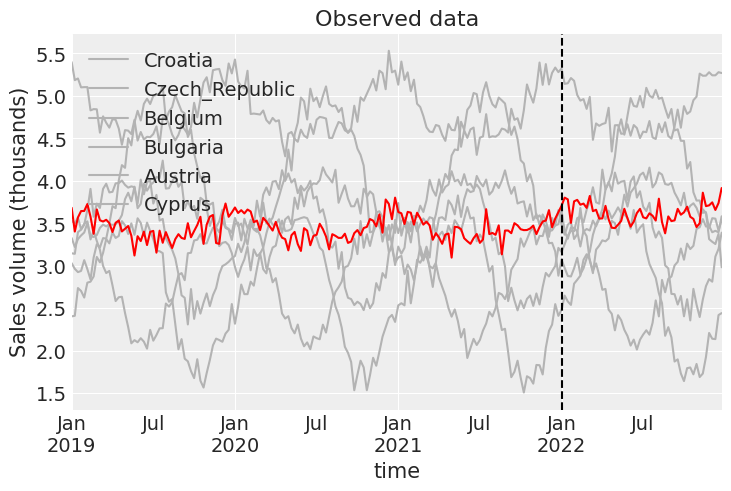

In [4]:
untreated = list(set(df.columns).difference({"Denmark"}))
ax = df[untreated].plot(color=[0.7, 0.7, 0.7])
df["Denmark"].plot(color="r", ax=ax)
ax.axvline(treatment_time, color="k", linestyle="--")
ax.set(title="Observed data", ylabel="Sales volume (thousands)");

This looks pretty nice. Though with the observation noise, it is not immediately obvious (by eye) that there is a treatment effect. Can we detect this with `CausalPy`?

## Is there a 'lift' in sales in Denmark?

In [5]:
result = cp.pymc_experiments.SyntheticControl(
    df,
    treatment_time,
    formula="Denmark ~ 0 + Austria + Belgium + Bulgaria + Croatia + Cyprus + Czech_Republic",
    prediction_model=cp.pymc_models.WeightedSumFitter(
        sample_kwargs={"target_accept": 0.95}
    ),
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


## Results

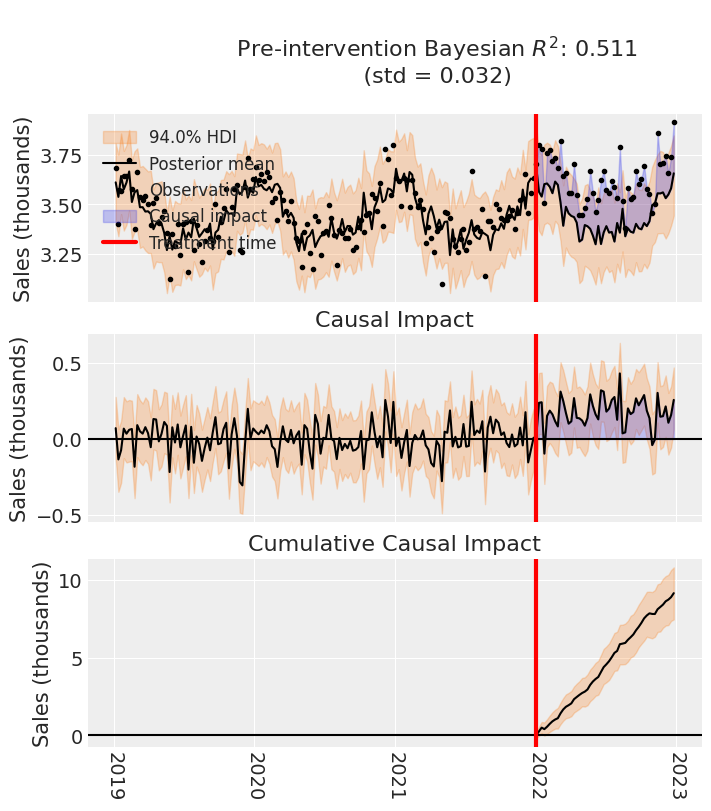

In [6]:
fig, ax = result.plot(plot_predictors=False)

# formatting
ax[2].tick_params(axis="x", labelrotation=-90)
ax[2].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax[2].xaxis.set_major_locator(mdates.YearLocator())
for i in [0, 1, 2]:
    ax[i].set(ylabel="Sales (thousands)")

Nice! By creting a simple model formula and one call to `CausalPy`, we have been able to evaluate the lift generated in the treated unit.

In this example, there is quite a lot of measurement noise, but because we are using Bayesian inference methods here, we have a precise and principled quantification in our uncertainty.

We can see that the Bayesian $R^2$ value for the pre-treatment data is about 0.5. This is not excellent, but pretty good for real-world data. It shows that the linear weighted combination model (the core of synthetic control) is doing a reasonable job at constructing a faux (i.e. synthetic) Denmark up until the treatment period.

This synthetic control Denmark is used to generate a counterfactual of what the sales would have been if the store renovation project had not been carried out. By looking at the difference we can estimate the causal impact, or we could also call it 'geographical lift'.

Over the year since implementation, we can see that the cumulative causal impact of sales in Denmark was about 10,000 units.

This is exactly the information needed by others in the data science team. They can use this figure (and even the uncertainty associated with it) and estimate how long it would take for the cost of rennovating other stores to result in a net profit.

You boss is very happy. You get a big end-of-year bonus.

## Beyond GeoLift
This example used geographical regions as the treatment units, but there is no _requirement_ for units to be geographical regions. 

For example, your units could be products. Maybe your company sells many different products and one (or a few of these) are chosen to be discounted. Did this intervention of discounting the price causally increase sales volumes? Synthetic control methods can answer this (and similar questions) just as easily.